In [1]:
import pandas as pd
import os
!pip install opencv-python
import cv2

In [2]:
from skimage.feature import hog
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns
import joblib

In [3]:
train_path = "data/train"
test_path = "data/test"
image_size = 128
random_state = 42
LABELS = {
    "Cat":0,
    "Dog":1
}
    

In [4]:
def preprocessing_image(img_path, img_size=image_size):
    image= cv2.imread(img_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image,(img_size,img_size))
    return image    
    

In [5]:
def extract_hog_features(image):
    features = hog (
        image,
        orientations =6,
        pixels_per_cell = (16,16),
        cells_per_block = (2,2),
        block_norm = "L2-Hys"
    )
    return features

In [6]:
def load_training_data(train_path):
    X, y = [] , []
    for category, label in LABELS.items():
        folder_path = os.path.join(train_path, category)
        for img_name in tqdm(os.listdir(folder_path),desc = f"Processing : {category}"):
            img_path = os.path.join(folder_path, img_name)

            image = preprocessing_image(img_path)
             # Skip unreadable images
            if image is None:
                continue
            features = extract_hog_features(image)

            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)
        


In [7]:
X,y = load_training_data(train_path)
print("Feature matrix shape :", X.shape)
print("Label shape:", y.shape)

Processing : Dog: 100%|██████████| 12499/12499 [03:45<00:00, 55.39it/s]


Feature matrix shape : (24997, 1176)
Label shape: (24997,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y,test_size=0.2, random_state = 42, stratify = y)

In [9]:
st = StandardScaler()
X_train = st.fit_transform(X_train)
X_val = st.transform(X_val)

In [10]:
svm = LinearSVC(class_weight="balanced", C = 1.0, max_iter = 50)
svm.fit(X_train, y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,None


In [12]:
y_pred = svm.predict(X_val)
print("Accuracy:", accuracy_score(y_pred,y_val))
print("Classification report")
print(classification_report(y_pred, y_val, target_names=["Cat","Dog"]))
      

Accuracy: 0.732
Classification report
              precision    recall  f1-score   support

         Cat       0.71      0.74      0.73      2406
         Dog       0.75      0.72      0.74      2594

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000



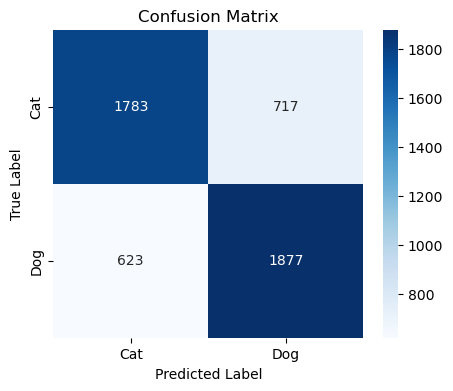

In [24]:
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot = True,
    fmt ="d",
    cmap= "Blues",
    xticklabels = ["Cat","Dog"],
    yticklabels = ["Cat","Dog"])
plt.xlabel("Predicted Label"),
plt.ylabel("True Label"),
plt.title("Confusion Matrix"), 
plt.show()


In [27]:
os.makedirs("models", exist_ok=True)
joblib.dump(svm,"models/svm_cat_dog_model.pkl")
joblib.dump(st,  "models/feature_scaler.pkl")
print("Model and Scaler saved successfully")


Model and Scaler saved successfully


In [28]:
def predict_image(image_path,model,scaler):
    image = preprocessing_image(image_path)
    features = extract_hog_features(image)
    features = st.transform([features])
    prediction = model.predict(features)[0]
    confidence = model.decision_function(features)[0]

    label = "Cat" if prediction == 0 else "Dog"
    return label, confidence
    
